### Build A Basic Chatbot With Langgraph(GRAPH API)

In [1]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages


In [2]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages:Annotated[list,add_messages]



In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm=ChatGroq(model="llama3-8b-8192")

In [5]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002334EFF8D70>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002334EFF9940>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [6]:
llm=init_chat_model("groq:llama3-8b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002334F0B1A90>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002334F0B2490>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [7]:
## Node Functionality
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

In [8]:
graph_builder=StateGraph(State)

## Adding node
graph_builder.add_node("llmchatbot",chatbot)
## Adding Edges
graph_builder.add_edge(START,"llmchatbot")
graph_builder.add_edge("llmchatbot",END)

## compile the graph
graph=graph_builder.compile()

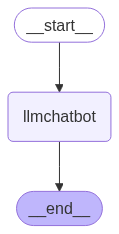

In [10]:
## Visualize the graph
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [11]:
response=graph.invoke({"messages":"Hi"})

In [12]:
response["messages"][-1].content

"Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [13]:
for event in graph.stream({"messages":"Hi How are you?"}):
    for value in event.values():
        print(value["messages"][-1].content)

I'm just a language model, I don't have emotions or feelings like humans do, but I'm functioning properly and ready to help with any questions or tasks you may have!


### Chatbot With Tool

In [14]:
from langchain_tavily import TavilySearch

tool=TavilySearch(max_results=2)
tool.invoke("What is langgraph")

{'query': 'What is langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
   'title': 'LangGraph Tutorial: What Is LangGraph and How to Use It?',
   'content': 'LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured and efficient manner. By managing the flow of data and the sequence of operations, LangGraph allows developers to focus on the high-level logic of their applications rather than the intricacies of agent coordination. Whether you need a chatbot that can handle various types of user requests or a multi-agent system that performs complex tasks, LangGraph provides the tools to build exactly what you need. LangGraph significantly simplifies the development of complex LLM applications by providing a structured framework for managing state and coordinating agent interaction

In [15]:
## Custom function
def multiply(a:int,b:int)->int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a*b

In [16]:
tools=[tool,multiply]

In [17]:
llm_with_tool=llm.bind_tools(tools)

In [18]:
llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002334F0B1A90>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002334F0B2490>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list 

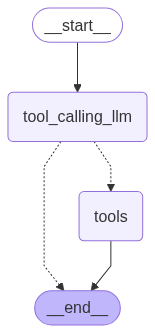

In [19]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))



In [20]:
response=graph.invoke({"messages":"What is the recent ai news"})

In [21]:
response['messages'][-1].content

'{"query": "latest ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.theguardian.com/technology/artificialintelligenceai", "title": "Artificial intelligence (AI) | The Guardian", "content": "## Artificial intelligence (AI)\\n\\n## 9 July 2025\\n\\nA robot playing chess\\n\\n### Futurist Adam Dorr on how robots will take our jobs: ‘We don’t have long to get ready – it’s going to be tumultuous’\\n\\n## 8 July 2025\\n\\nIllustration shows 3D-printed miniature model of Elon Musk and X logo\\n\\n### Musk’s AI firm forced to delete posts praising Hitler from Grok chatbot\\n\\nGrok logo\\n\\n### Musk’s Grok AI bot generates expletive-laden rants to questions on Polish politics [...] ### How terrorist groups are leveraging AI to recruit and finance their operations\\n\\n## 7 July 2025\\n\\nJohn Caudwell\\n\\n### Billionaire Labour backer John Caudwell ‘nervous’ about Starmer\\n\\nEmma Beddington\\n\\n### The worst thing about AI? That stupid 

In [22]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent ai news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (f0vcm4164)
 Call ID: f0vcm4164
  Args:
    query: latest ai news
    search_depth: advanced
    time_range: day
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "latest ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.theguardian.com/technology/artificialintelligenceai", "title": "Artificial intelligence (AI) | The Guardian", "content": "## Artificial intelligence (AI)\n\n## 9 July 2025\n\nA robot playing chess\n\n### Futurist Adam Dorr on how robots will take our jobs: ‘We don’t have long to get ready – it’s going to be tumultuous’\n\n## 8 July 2025\n\nIllustration shows 3D-printed miniature model of Elon Musk and X logo\n\n### Musk’s AI

In [15]:
response=graph.invoke({"messages":"What is 5 multiplied by 2"})
for m in response['messages']:
    m.pretty_print()


================================ Human Message =================================

What is 5 multiplied by 2
================================== Ai Message ==================================
Tool Calls:
  multiply (g6rrcbzyx)
 Call ID: g6rrcbzyx
  Args:
    a: 5
    b: 2
================================= Tool Message =================================
Name: multiply

10


In [23]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (r5wpazhpf)
 Call ID: r5wpazhpf
  Args:
    query: recent ai news
    search_depth: advanced
    time_range: day
  multiply (xm6d5gc0k)
 Call ID: xm6d5gc0k
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.theatlantic.com/technology/archive/2025/07/ai-radicalization-civil-war/683460/", "title": "The AI Industry Is Radicalizing - The Atlantic", "content": "start-ups promise “full automation of the economy,” “unbounded connection” with millions of AI personas, “limitless” memory, a solution to “all disease.” In recent weeks, several AI researchers and f

### ReAct Agent Architecture

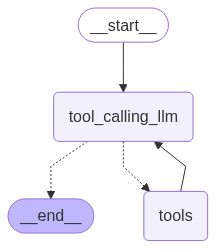

In [24]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (zw994xqcc)
 Call ID: zw994xqcc
  Args:
    query: recent ai news
    search_depth: advanced
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://nypost.com/2025/07/02/business/chinese-tech-firms-are-gaining-fast-on-silicon-valley-in-ai-race-report/", "title": "Chinese tech firms are gaining fast on Silicon Valley in AI race: report - nypost.com", "score": 0.6615081, "published_date": "Wed, 02 Jul 2025 18:39:00 GMT", "content": "Global banking giants HSBC and Standard Chartered have launched internal testing of the Chinese model, while Saudi Aramco, the world’s largest

## Adding Memory In Agentic Graph

In [26]:
response=graph.invoke({"messages":"Hello my name is Suraj kumar"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello my name is Suraj kumar
================================== Ai Message ==================================
Tool Calls:
  multiply (rnt842znz)
 Call ID: rnt842znz
  Args:
    a: 1
    b: 0
================================= Tool Message =================================
Name: multiply

0
================================== Ai Message ==================================
Tool Calls:
  tavily_search (y6z4tegtj)
 Call ID: y6z4tegtj
  Args:
    query: who is Suraj Kumar
    search_depth: advanced
    time_range: None
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "who is Suraj Kumar", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://en.wikipedia.org/wiki/Kumar_Suraj", "title": "Kumar Suraj - Wikipedia", "content": "Wikipedia\n\n# Kumar Suraj\n\nKumar Suraj (born 16 March 1997) is an Indian 

In [27]:
response=graph.invoke({"messages":"What is my name"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is my name
================================== Ai Message ==================================

/tool-use>
{
  "tool_calls": [
    {
      "id": "pending",
      "type": "function",
      "function": {
        "name": "multiply"
      },
      "parameters": {
        "a": 0,
        "b": 1
      }
    }
  ]
}</tool-use>


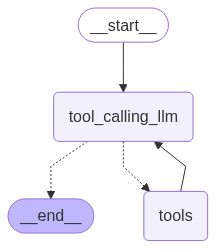

In [24]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile(checkpointer=memory)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
config={"configurable":{"thread_id":"1"}}

response=graph.invoke({"messages":"Hi my name is Krish"},config=config)

response



{'messages': [HumanMessage(content='Hi my name is Krish', additional_kwargs={}, response_metadata={}, id='e55bf5c4-e660-4919-ab56-053030ab687d'),
  AIMessage(content='Nice to meet you, Krish! Is there something I can help you with or would you like to chat?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 2193, 'total_tokens': 2216, 'completion_time': 0.033208577, 'prompt_time': 0.489441871, 'queue_time': 3.1984534190000002, 'total_time': 0.522650448}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'stop', 'logprobs': None}, id='run--b6cac6ef-4b1a-4ece-b1ed-fad73ad85355-0', usage_metadata={'input_tokens': 2193, 'output_tokens': 23, 'total_tokens': 2216})]}

In [27]:
response['messages'][-1].content

'Nice to meet you, Krish! Is there something I can help you with or would you like to chat?'

In [28]:
response=graph.invoke({"messages":"Hey what is my name"},config=config)

print(response['messages'][-1].content)

Your name is Krish.


In [30]:
response=graph.invoke({"messages":"Hey do you remember mmy name"},config=config)

print(response['messages'][-1].content)

Your name is Krish, right?


### Streaming

In [44]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

In [45]:
def superbot(state:State):
    return {"messages":[llm.invoke(state['messages'])]}

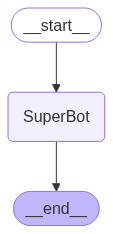

In [46]:
graph=StateGraph(State)

## node
graph.add_node("SuperBot",superbot)
## Edges

graph.add_edge(START,"SuperBot")
graph.add_edge("SuperBot",END)


graph_builder=graph.compile(checkpointer=memory)


## Display
from IPython.display import Image, display
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [47]:
## Invocation

config = {"configurable": {"thread_id": "1"}}

graph_builder.invoke({'messages':"Hi,My name is Krish And I like cricket"},config)

{'messages': [HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwargs={}, response_metadata={}, id='4bbd93a6-5c99-476d-af9b-2542f400b2be'),
  AIMessage(content="Hi Krish! Nice to meet you! Cricket is a great sport, isn't it? Who's your favorite cricketer or team? Do you play cricket yourself or just enjoy watching and following the game?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 20, 'total_tokens': 63, 'completion_time': 0.103689851, 'prompt_time': 0.017182506, 'queue_time': 3.3513802249999998, 'total_time': 0.120872357}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'stop', 'logprobs': None}, id='run--46e8c88b-782a-438f-9ccc-58ab8668c0bf-0', usage_metadata={'input_tokens': 20, 'output_tokens': 43, 'total_tokens': 63})]}

### Streaming 
Methods: .stream() and astream()

- These methods are sync and async methods for streaming back results.

Additional parameters in streaming modes for graph state

- **values** : This streams the full state of the graph after each node is called.
- **updates** : This streams updates to the state of the graph after each node is called.

In [ ]:
# Create a thread
config = {"configurable": {"thread_id": "3"}}

for chunk in graph_builder.stream({'messages':"Hi,My name is Krish And I like cricket"},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content="Nice to meet you, Krish! It's great to hear that you like cricket! What's your favorite team or player in cricket?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 20, 'total_tokens': 48, 'completion_time': 0.067597787, 'prompt_time': 0.017155746, 'queue_time': 3.961062715, 'total_time': 0.084753533}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'stop', 'logprobs': None}, id='run--dd517fd5-951c-4ba1-9af4-e5eddab1c545-0', usage_metadata={'input_tokens': 20, 'output_tokens': 28, 'total_tokens': 48})]}}


In [49]:
for chunk in graph_builder.stream({'messages':"Hi,My name is Krish And I like cricket"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwargs={}, response_metadata={}, id='2bdefe18-5571-41a9-9c62-59f9b739b6b6'), AIMessage(content="Nice to meet you, Krish! It's great to hear that you like cricket! What's your favorite team or player in cricket?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 20, 'total_tokens': 48, 'completion_time': 0.067597787, 'prompt_time': 0.017155746, 'queue_time': 3.961062715, 'total_time': 0.084753533}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'stop', 'logprobs': None}, id='run--dd517fd5-951c-4ba1-9af4-e5eddab1c545-0', usage_metadata={'input_tokens': 20, 'output_tokens': 28, 'total_tokens': 48}), HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwargs={}, response_metadata={}, id='12985285-9873-4723-82c7-3864b7f001e4')]}
{'messages': [HumanMessage(content='Hi,My name is Krish And I lik

In [50]:
# Create a thread
config = {"configurable": {"thread_id": "4"}}

for chunk in graph_builder.stream({'messages':"Hi,My name is Krish And I like cricket"},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content="Hello Krish! Nice to meet you! It's great to know that you like cricket! Which team do you support?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 20, 'total_tokens': 45, 'completion_time': 0.041678799, 'prompt_time': 0.017140167, 'queue_time': 5.561800282, 'total_time': 0.058818966}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'stop', 'logprobs': None}, id='run--e14c0aff-5759-4df1-9ec3-def7a3a150dd-0', usage_metadata={'input_tokens': 20, 'output_tokens': 25, 'total_tokens': 45})]}}


In [51]:
for chunk in graph_builder.stream({'messages':"I also like football"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwargs={}, response_metadata={}, id='28871637-a931-4c6d-a84b-5219d4aaf9c5'), AIMessage(content="Hello Krish! Nice to meet you! It's great to know that you like cricket! Which team do you support?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 20, 'total_tokens': 45, 'completion_time': 0.041678799, 'prompt_time': 0.017140167, 'queue_time': 5.561800282, 'total_time': 0.058818966}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'stop', 'logprobs': None}, id='run--e14c0aff-5759-4df1-9ec3-def7a3a150dd-0', usage_metadata={'input_tokens': 20, 'output_tokens': 25, 'total_tokens': 45}), HumanMessage(content='I also like football', additional_kwargs={}, response_metadata={}, id='cdc89c65-01b1-4ccf-ab6a-48aed71fefd4')]}
{'messages': [HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwargs={},

In [52]:
config = {"configurable": {"thread_id": "5"}}

async for event in graph_builder.astream_events({"messages":["Hi My name is Krish and I like to play cricket"]},config,version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi My name is Krish and I like to play cricket']}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'fc9179e8-7f2a-40ea-86d8-80d86b0ab3b6', 'metadata': {'thread_id': '5'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi My name is Krish and I like to play cricket', additional_kwargs={}, response_metadata={}, id='5cbc8727-5339-4a8a-9d63-09267608e1af')]}}, 'name': 'SuperBot', 'tags': ['graph:step:1'], 'run_id': '8108e5d5-e6eb-44a0-8057-41b3e38e8eef', 'metadata': {'thread_id': '5', 'langgraph_step': 1, 'langgraph_node': 'SuperBot', 'langgraph_triggers': ('branch:to:SuperBot',), 'langgraph_path': ('__pregel_pull', 'SuperBot'), 'langgraph_checkpoint_ns': 'SuperBot:81dc6040-44c3-d3b6-96a8-292b5d7a3caa'}, 'parent_ids': ['fc9179e8-7f2a-40ea-86d8-80d86b0ab3b6']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Hi My name is Krish and I like to pla